## 셀피 스티커 앱 만들기 📸 

___

💬 SNOW 같은 카메라 필터 어플은 어떻게 작동할까요? 이번 노트북은 사진을 입력받아 **얼굴 영역을 인식하고 적절한 위치에 스티커 이미지를 부착하는 프로젝트**입니다.

스티커 어플을 설계하려면 고려해야할 사항들이 몇가지 있습니다. 

📍 **일단, 입력값인 동영상(연속된 사진)에서 얼굴을 인식해내야 합니다.**

📍 **인식한 얼굴의 알맞은 위치에 스티커를 부착해야합니다.** 만약 고양이 수염을 달고 싶다면 코와 입의 사이 공간에 스티커가 들어가야합니다.

📍 **만약 사람이 가까이 다가오면 스티커도 커지고 사람이 멀어지면 스티커는 작아져야합니다.** 

이런 여러가지 과제를 가지고 스티커앱 만들기에 도전해봅니다!

---

### 0. 어떻게 구현할까? 아웃라인 잡기

**스티커를 잘 붙이려면 이목구비의 위치를 파악하는 것이 중요합니다.** 이런 중요 포인트의 위치를 찾아내는 기술을 **랜드마크(landmark)**라고 합니다. 얼굴의 경우 눈, 코, 입, 턱이 주요 포인트가 됩니다.

스티커 어플을 구현하기 위해서 다음 과정들을 수행합니다.

1. 얼굴이 포함된 사진을 준비한다.



2. 사진으로부터 얼굴의 `bounding box`를 찾는다.



3. 눈, 코, 입과 같은 `face landmark`를 파악한다.



4. 원하는 위치에 스티커를 부착하여 출력한다.

---

### 1. 이미지 준비하기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

이미지 처리를 위한 `opencv`와 `matplotlib`을 불러옵니다. 그런데 **`opencv`는 BGR(Blue,Green,Red) 이미지 채널을 사용하기 때문에 우리에게 익숙한 RGB 채널로 바꿔줘야 합니다.**

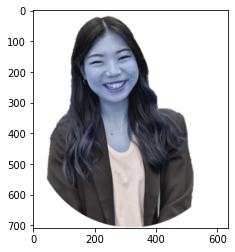

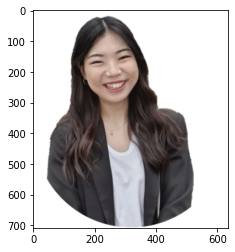

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # bgr이미지를 rgb이미지로 바꿔줍니다
plt.imshow(img_rgb)
plt.show()

---

### 2. 얼굴 인식하기

눈, 코, 입을 인식하기 전에 먼저 얼굴 면적을 지정해 줍니다. 이렇게 지정한 얼굴 면적을 `bounding box`라고 부릅니다. `bounding box`를 찾는 과정에서 딥러닝 모델이 사용됩니다. Object Detection, 그 중에서도 Face Detection을 수행하는 모델이 여러가지 있는데, 여기서는 `Dlib`의 **HOG와 Linear SVM face detector**를 사용할 것입니다.

`detector`를 선언하고 얼굴의 `bounding box`를 추출합니다.

In [3]:
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)	#bgr이미지 rgb로 변경
dlib_rects = detector_hog(img_rgb, 1)

찾은 얼굴을 출력해봅시다.

rectangles[[(159, 118) (345, 304)]]


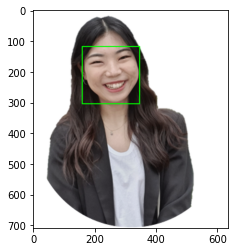

In [4]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

모델이 얼굴을 잘 인식하고 있음을 알 수 있습니다.

---

### 3. 얼굴 랜드마크 찾기

이제 얼굴을 블록지정 했으니 블록 안의 눈, 코, 입, 턱 등을 찾아 볼 겁니다. `bounding box`로 잘라낸 얼굴 이미지에서 이목구비의 위치를 추론하는 것을 `face landmark localization`이라고 합니다. `Dlib`에서 제공하는 이미 학습된 모델을 사용하여 얼굴의 랜드마크를 찾습니다. 공개되어 있는 weight file을 다운받아 압축을 푼 후 사용합니다.

In [5]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

![Dlib face landmark](https://blog.kakaocdn.net/dn/dkV2PW/btrqnkMRoUs/4fzijgMW9LMCTxnEhpZKz0/img.png)

`bounding box`안에서 위의 68개의 `face landmark`를 찾아 `list_landmark`라는 리스트에 저장합니다.

In [6]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아낸다.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

찾아낸 `face landmark`를 출력해봅시다.

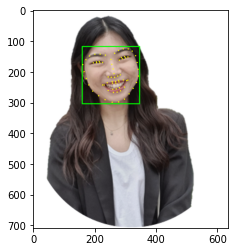

In [7]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

`face landmark`도 잘 찾아졌습니다!

---

### 4. 스티커 적용하기

 스티커를 얼굴에 붙이려면 두 가지를 고려해야 합니다.
 
 1) 스티커의 위치: 저는 선글라스 스티커를 달고 싶기 때문에 미간의 가운데 점(28번 랜드마크)이 스티커 이미지의 중앙에 오도록 해야합니다.
 
 2) 스티커의 크기: 스티커의 크기는 `bounding box`의 크기 정도로 설정하면 될 것 같습니다.

먼저 미간의 좌표값을 확인합니다.

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[28]) # 미간의 index는 28 입니다
    x = landmark[28][0]
    y = landmark[28][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(255, 176)
(x,y) : (255,83)
(w,h) : (187,187)


그 다음, 준비해둔 스티커 이미지를 `bounding box` 크기로 바꿔줍니다.

(187, 187, 3)


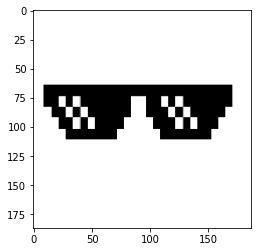

In [9]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/thuglife.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

이미지 시작점이 왼쪽 위(top-left) 좌표이기 때문에 x, y 값을 조정해줍니다.

In [10]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (162,83)


만약 스티커 이미지가 원본 이미지의 범위를 넘어가는 경우를 대비하여 다음 코드를 작성합니다.

In [11]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

np.where 함수를 이용하여 원본 이미지와 스티커 이미지를 합성해줍니다.

In [12]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

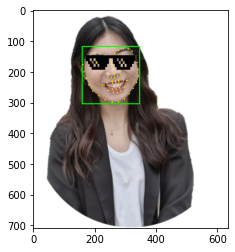

In [13]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

`bounding box`와 `face landmark`를 표시하지 않은 최종 합성 이미지를 출력합니다.

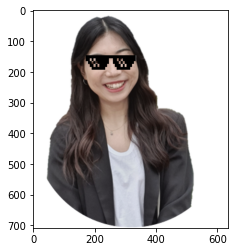

In [14]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

___

___

### 💡 더 다듬어 보기

💬 얼굴이 살짝 기울어 있기 때문에 스티커를 제대로 부착하려면 스티커의 각도를 조절해야 합니다.

💬 선글라스의 투명도를 조금 낮추어서 원본 이미지가 투영되어 보이게 만들어 봅시다.


___

`img_bgr`파일이 변경되었기 때문에 다시 원본 이미지를 불러와 줍니다.

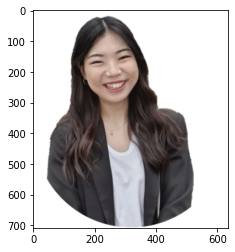

In [15]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()     
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.show()

`bounding box`를 다시 설정하고

rectangles[[(159, 118) (345, 304)]]


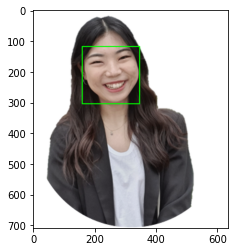

In [16]:
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)	#bgr이미지 rgb로 변경
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

`face landmark`도 다시 표시해 줍니다.

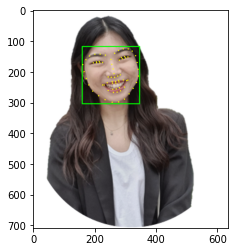

In [17]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

자, 이제 각도 조절과 투명도 조절 기능을 추가한 코드를 작성합니다.

타겟이 되는 랜드마크의 좌표값을 구하고

In [18]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[28]) # 미간의 index는 28 입니다
    x = landmark[28][0]
    y = landmark[28][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(255, 176)
(x,y) : (255,83)
(w,h) : (187,187)


스티커 이미지를 불러오는데, **여기서 이미지를 회전시켜서 `rotated_img`에 저장합니다.** `getRotationMatrix2D()`와 `warpAffine()`을 이용합니다.

(187, 187, 3)


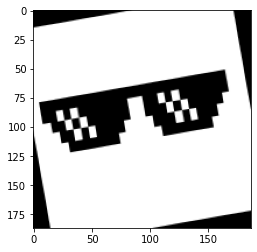

In [19]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/thuglife.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

rotation = cv2.getRotationMatrix2D((w/2, h/2), 10, 1)
rotated_img = cv2.warpAffine(img_sticker, rotation, (w,h))


plt.imshow(rotated_img)

스티커 이미지가 삽입될 좌표값을 설정해주고,

In [20]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (162,83)


원본 이미지와 스티커 이미지를 합성합니다. **이때, `addWeighted()`를 이용하여 원본 이미지와 스티커 이미지의 투명도(가중치)를 조정해줍니다.**

In [21]:
sticker_area = img_show[refined_y:refined_y+rotated_img.shape[0], refined_x:refined_x+rotated_img.shape[1]]
img_show[refined_y:refined_y+rotated_img.shape[0], refined_x:refined_x+rotated_img.shape[1]] = \
        np.where(rotated_img==0, cv2.addWeighted(sticker_area, 0.5, rotated_img, 0.5, 0), sticker_area).astype(np.uint8)

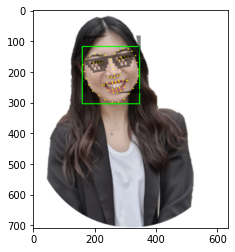

In [22]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

**각도가 조정된 선글라스가 약간 투명하게 합성된 것을 확인할 수 있습니다!**
그런데, 스티커 이미지가 회전되면서 생긴 가장자리 부분까지 합성이 되어버렸네요. 이건 어떻게 해결하지...(이마짚)

아무튼 결과 이미지를 출력해봅니다.

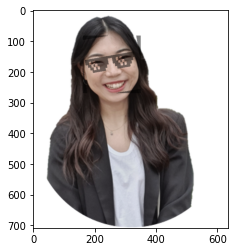

In [23]:
sticker_area = img_bgr[refined_y:refined_y+rotated_img.shape[0], refined_x:refined_x+rotated_img.shape[1]]
img_bgr[refined_y:refined_y+rotated_img.shape[0], refined_x:refined_x+rotated_img.shape[1]] = \
        np.where(rotated_img==0, cv2.addWeighted(sticker_area, 0.5, rotated_img, 0.5, 0), sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

___

## 🤔 회고

### 1. 모델이 주어져서 몇 가지 변수만 변형하면 얼굴과 이목구비 인식이 가능하다는 점이 놀라웠습니다! (근데 처음부터 혼자 하라 그러면 못할듯)

### 2. np.where의 쓰임새와 img_sticker==0의 의미를 잘 몰라서 헤매느라 시간이 꽤 걸렸습니다. 결국 해결은 했지만 완벽하게 이해하지는 못한 느낌... 좀 더 찾아보고 정리해야할 것 같습니다.

### 3. 사실 스티커의 각도를 조절할 때, 코와 미간을 잇는 선을 기준으로 각도를 자동으로 계산하여 스티커 이미지를 tilt하는 식으로 코드를 짜고 싶었으나 현격히 부족한 파이썬 실력으로 실패... 일단 수동으로 10도의 값을 지정해서 넣었습니다. 나중에는 자동화시켜서 구현할 수 있기를 바랍니다.

### 4. 스티커 이미지를 회전시키면서 가장자리에 의도치 않은 형태가 들어갔는데, 이건 해결을 어떻게 하는지 잘 모르겠습니다. png 파일 자체가  배경이 없어서 회전시킨다고 갑자기 가장자리가 드러나지는 않을 줄 알았는데 원인을 찾아봐야 겠습니다.

### 5. 쉽진 않았지만 그래도 바로바로 눈에 보이는 프로젝트여서 굉장히 재미있게 할 수 있었습니다. 왠지 곧 정말 셀카 어플도 만들 수 있을 것 같은 기분!(아님)